# Import packages & Load data


The features in this dataset include the following:
- customer demographic data: Gender, SeniorCitizen, Partner, Dependents
- subscribed services: PhoneService, MultipleLine, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies
- customer account information: CustomerID, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Tenure

Target is Churn, which has binary classes 1 and 0.

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import f1_score, mutual_info_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.dummy import DummyClassifier
import math
import matplotlib.pyplot as plt
from utils import helper

sns.set_palette(helper.PALETTE)

In [2]:
telco_df = pd.read_csv('dataset/customer_raw.csv')

In [3]:
# Data overview: check duplicates, missing values, unique values of each columns and datatype.
print(f"\nCheck duplicates: {telco_df.duplicated().sum()}")
print(f"\nRows & Columns  : {telco_df.shape}")
print(f"\nMissing values : {telco_df.isnull().sum().values.sum()}")

null_counts = telco_df.isnull().sum()
for col, cnt in null_counts.items():
    if cnt > 0:
        print(f"\nColumn '{col}' has {cnt} null records.")

print(f"\nDatatype: {telco_df.info()}")
for col in telco_df.columns:
    print(f"Column {col}: {telco_df[col].unique()}, \n")


Check duplicates: 0

Rows & Columns  : (7043, 21)

Missing values : 11

Column 'TotalCharges' has 11 null records.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   70

# Data Cleaning

- Change datatype: `TotalCharges`
- Drop unnecessary columns: `customerID`
- Drop 11 value-missing rows of column `TotalCharges` because all customers with null values in the `TotalCharges` column also have a corresponding `tenure` value of 0 (0.15% missing data).
- Drop outlier of `tenure` = 458 (based on stats below)

In [4]:
print(f"{telco_df.describe()}")
print(f"\n{telco_df['tenure'].value_counts().sort_index(ascending=False)[:5]}")

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7032.000000
mean     32.435752       64.761692   2283.300441
std      25.075228       30.090047   2266.771362
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3794.737500
max     458.000000      118.750000   8684.800000

tenure
458      1
72     362
71     170
70     119
69      95
Name: count, dtype: int64


In [5]:
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')
telco_df.drop(columns='customerID', inplace=True)
telco_df.dropna(subset=['TotalCharges'], inplace=True)
telco_df.drop(index=telco_df[telco_df['tenure']==458].index, inplace=True)

# Data Exploration 

In [6]:
cat_features = list(set(helper.get_categorical_features(telco_df)) - {'Churn'})
num_features = helper.get_numerical_features(telco_df)

## Target value

**Target value**

The majority 'No Churn' accounts for 73.42% of the data, indicating an imbalance. However, it's not a big problem that requires immediate fixing. We can assess the prediction accuracy and decide later.

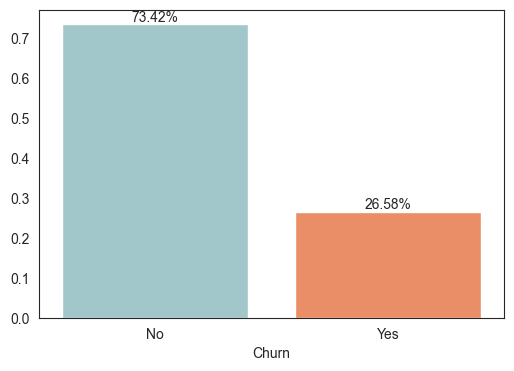

In [7]:
churn_df = telco_df["Churn"].value_counts(normalize=True)
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.barplot(x=churn_df.index, y=churn_df.values)
for i, v in enumerate(churn_df.values):
    ax.text(i, v, f"{v*100:.2f}%", ha='center', va='bottom')

**Numericical features**

Based on the pair plot, it appears feasible to divide these features into categories that can potentially differentiate churn and non-churn customers.

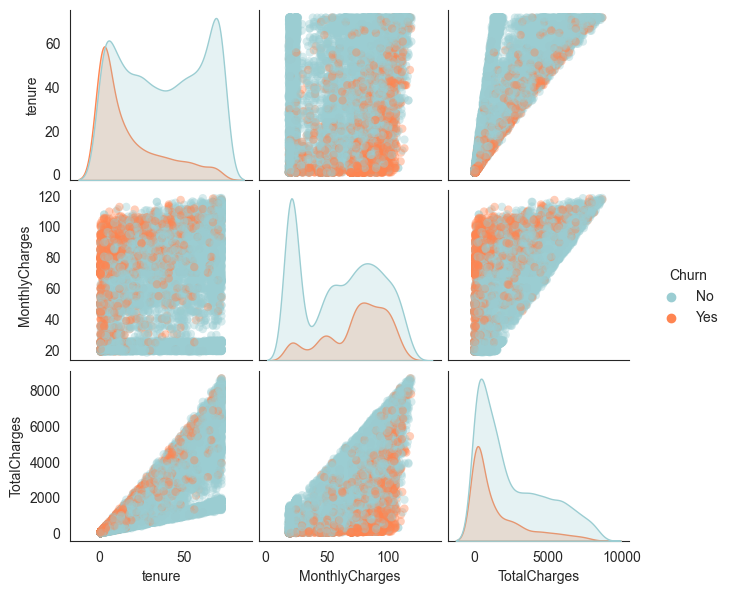

In [8]:
sns.pairplot(telco_df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], \
            hue='Churn', plot_kws=dict(alpha=.4, edgecolor='none'), height=2, aspect=1.1)
plt.show()

Key conclusions from the histogram analysis:
- High monthly charges are associated with a higher churn rate.
- New customers with low tenure are more likely to churn.
- Customers with high total charges are less likely to churn. This indicates that higher total charges contribute to a lower likelihood of customer attrition.

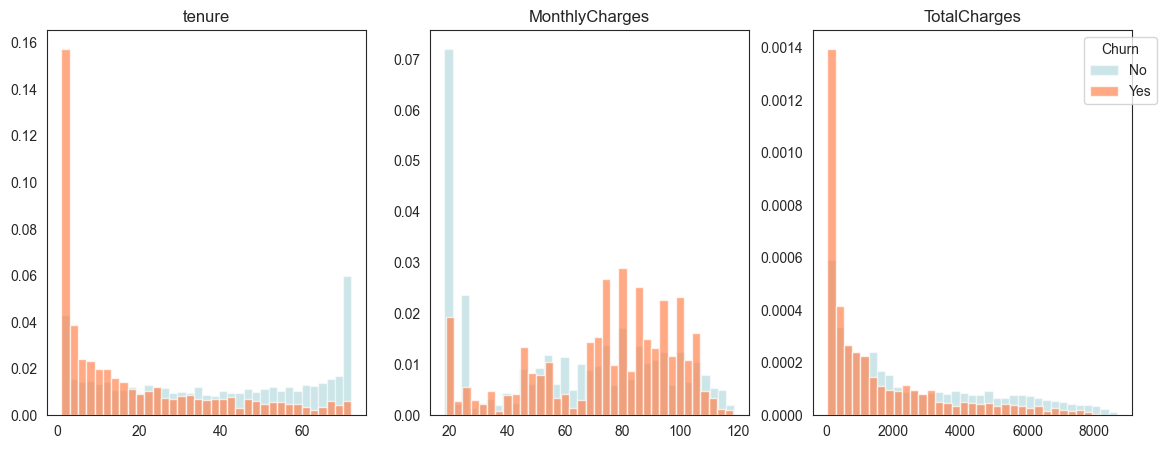

In [9]:
helper.histplot_num_feature_by_target(telco_df, cols=3)

**Categorical variables**

A good feature is when we can distinguish between churn and non-churn customers, especially when the ratio is different. 

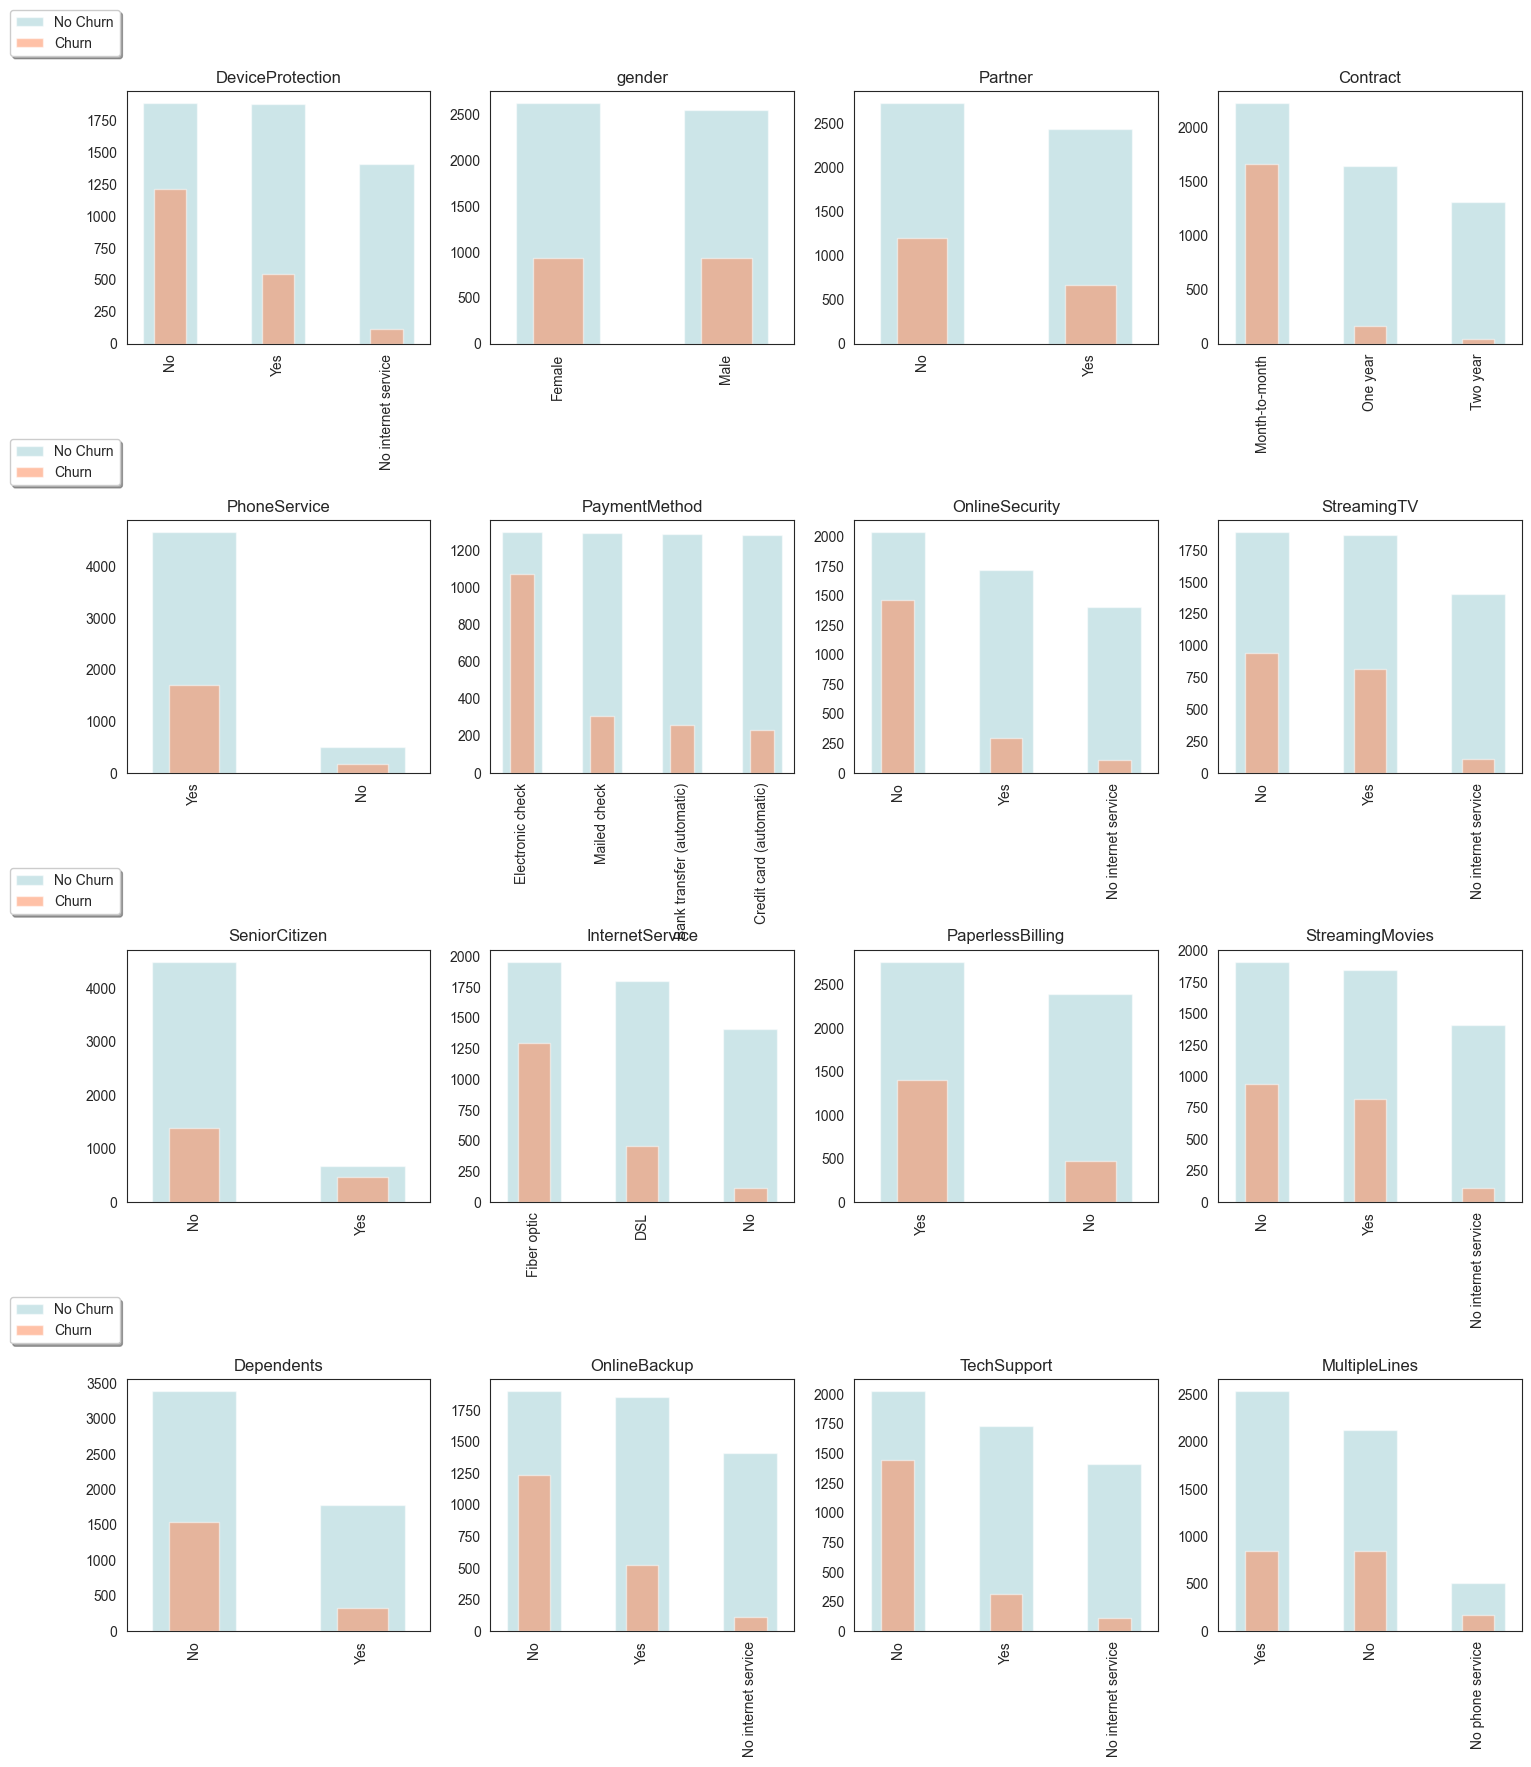

In [9]:
helper.barplot_cat_feature_by_target(telco_df, features=cat_features)

## Feature Engineering

- **Drop unncessary features**: `gender`, `MultipleLines`, `PhoneService`
- **Encoding categorical variables**: I use label encoding to replace values with numerical ones and dummy encoding to create new binary columns. These binary columns also don't have too many unqiue values.
- **Normalization for numerical varibales**: Because the distribution of (`tenure`, `MontlyCharges`, and `TotalCharges`) are not Gaussian or the standard deviation is very small, the min-max scaler works better.
- **Create new feature**: I bucketsize `tenure`, `MonthlyCharges`, and `TotalCharges` features by carefully selecting these separation boundaries to attempt to separate the churn and non-churn cases.

In [10]:
def compute_mutual_information(categorical_series):
    return mutual_info_score(categorical_series, telco_df.Churn)

cat_variables = list(set(cat_features) - {'Churn'})
feature_importance = telco_df[cat_variables].apply(compute_mutual_information).sort_values(ascending=False)
print(feature_importance)

Contract            0.098231
OnlineSecurity      0.064570
TechSupport         0.062861
InternetService     0.055388
OnlineBackup        0.046656
PaymentMethod       0.044471
DeviceProtection    0.043817
StreamingMovies     0.031930
StreamingTV         0.031814
PaperlessBilling    0.019136
Dependents          0.014282
Partner             0.011398
SeniorCitizen       0.010529
MultipleLines       0.000796
PhoneService        0.000069
gender              0.000037
dtype: float64


**Drop features**

As indicated earlier, the variables gender, PhoneService, and MultipleLines demonstrate a mutual information score that is very close to 0. This implies that these variables have a weak association with the target variable. These findings corroborate our previous observations when visually analyzing the data.

In [11]:
transformed_telco_df = telco_df.drop(columns=['gender', 'MultipleLines', 'PhoneService'])

**Bucketsizing**

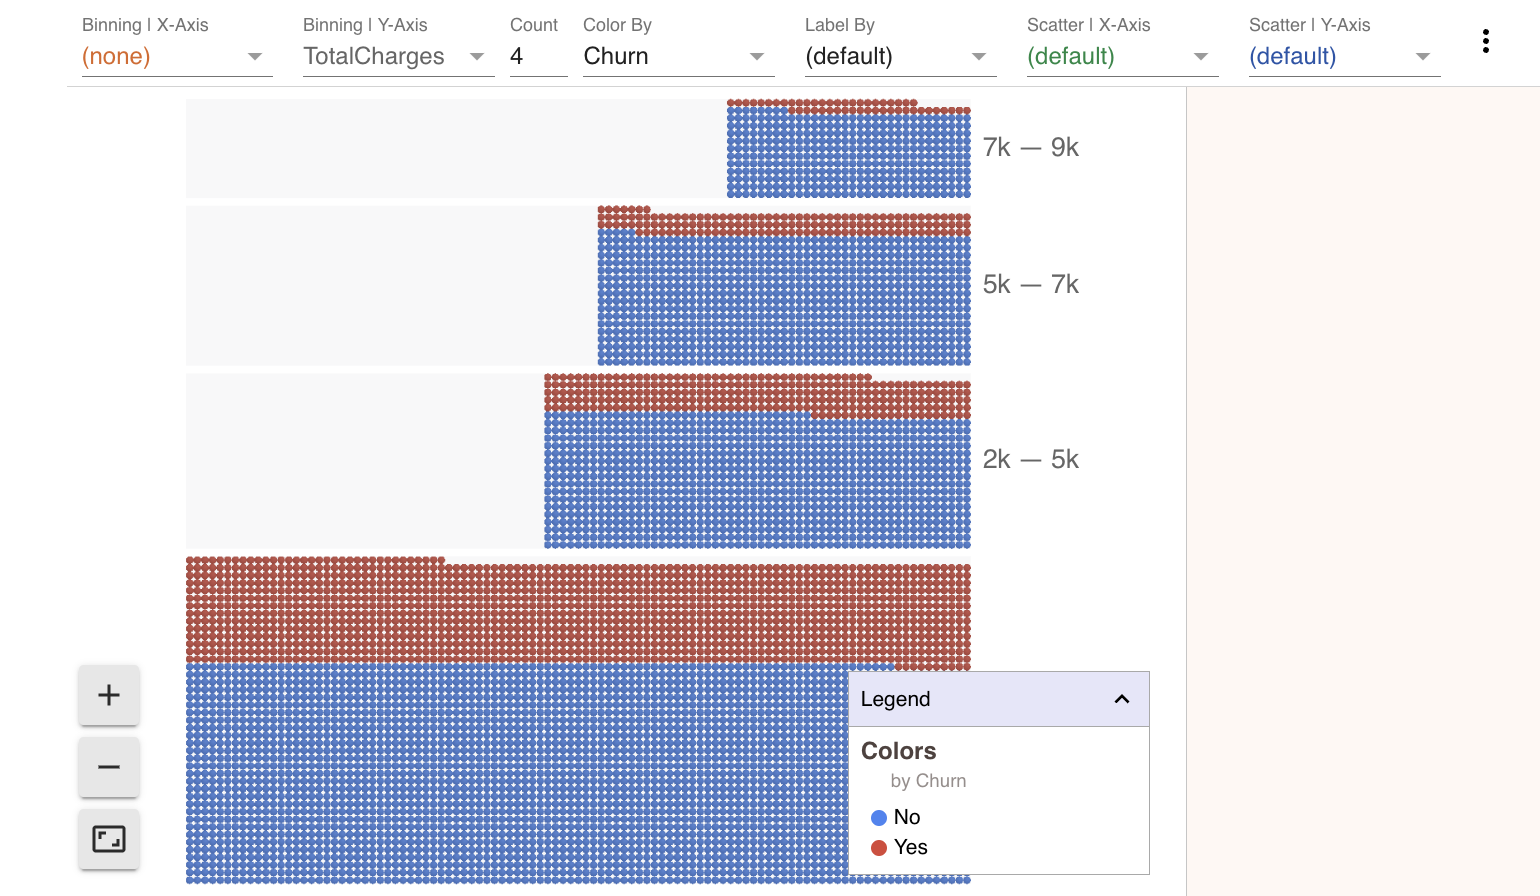

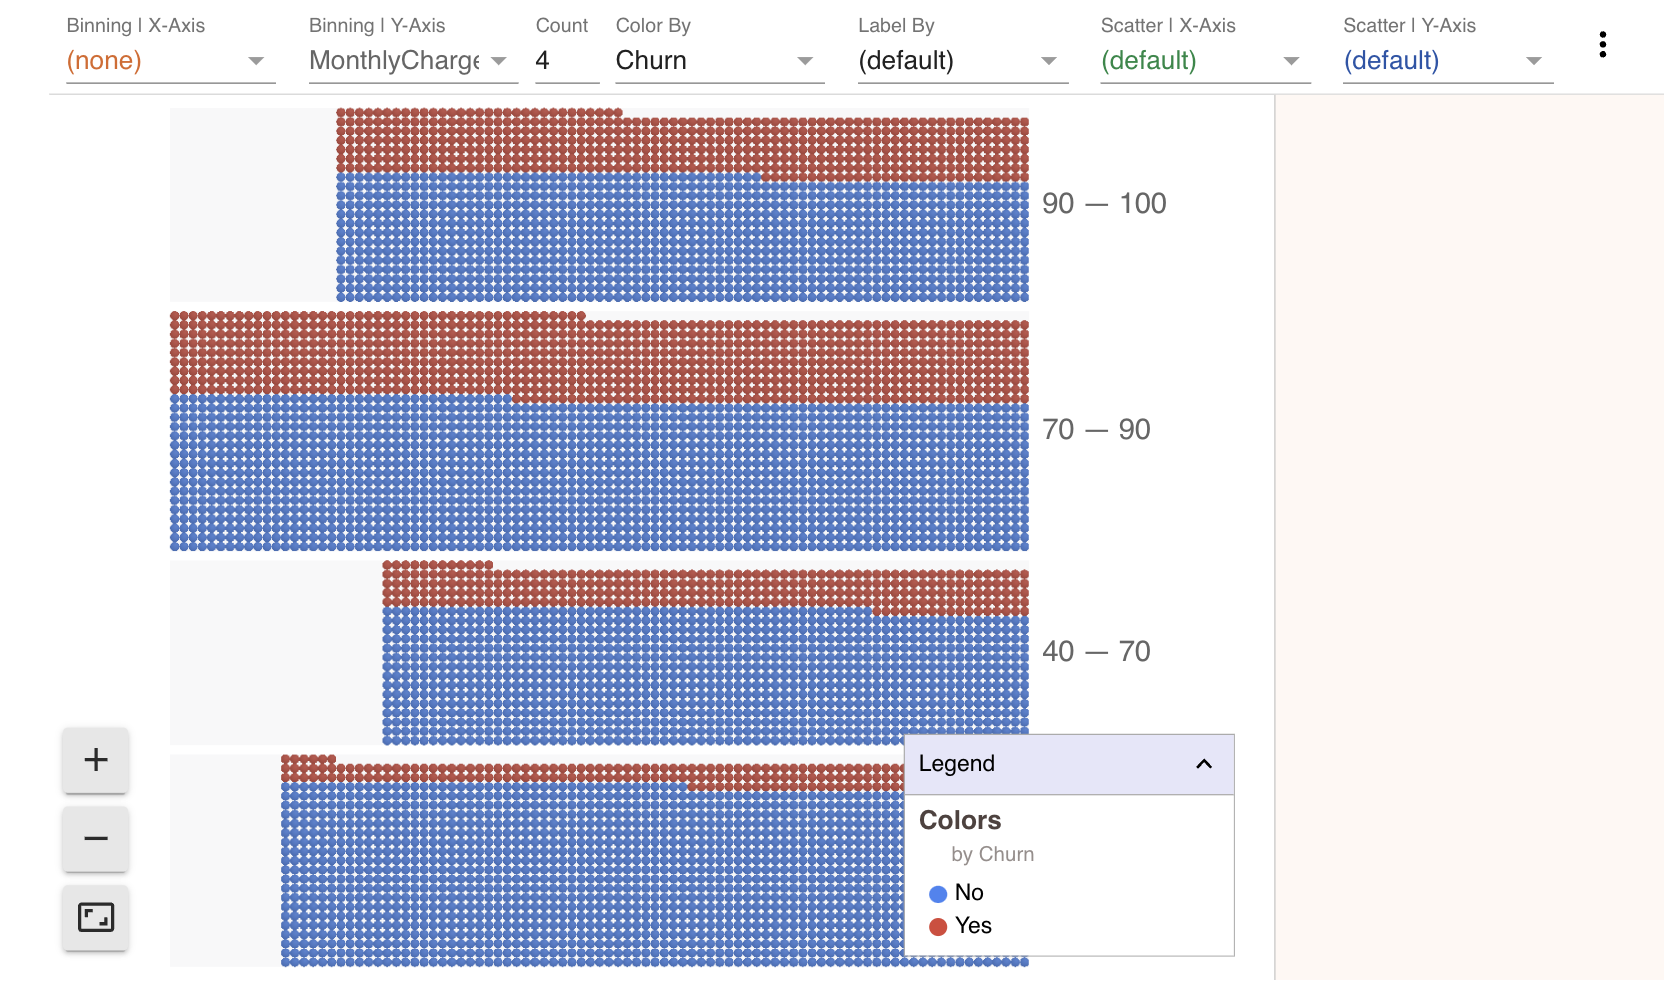

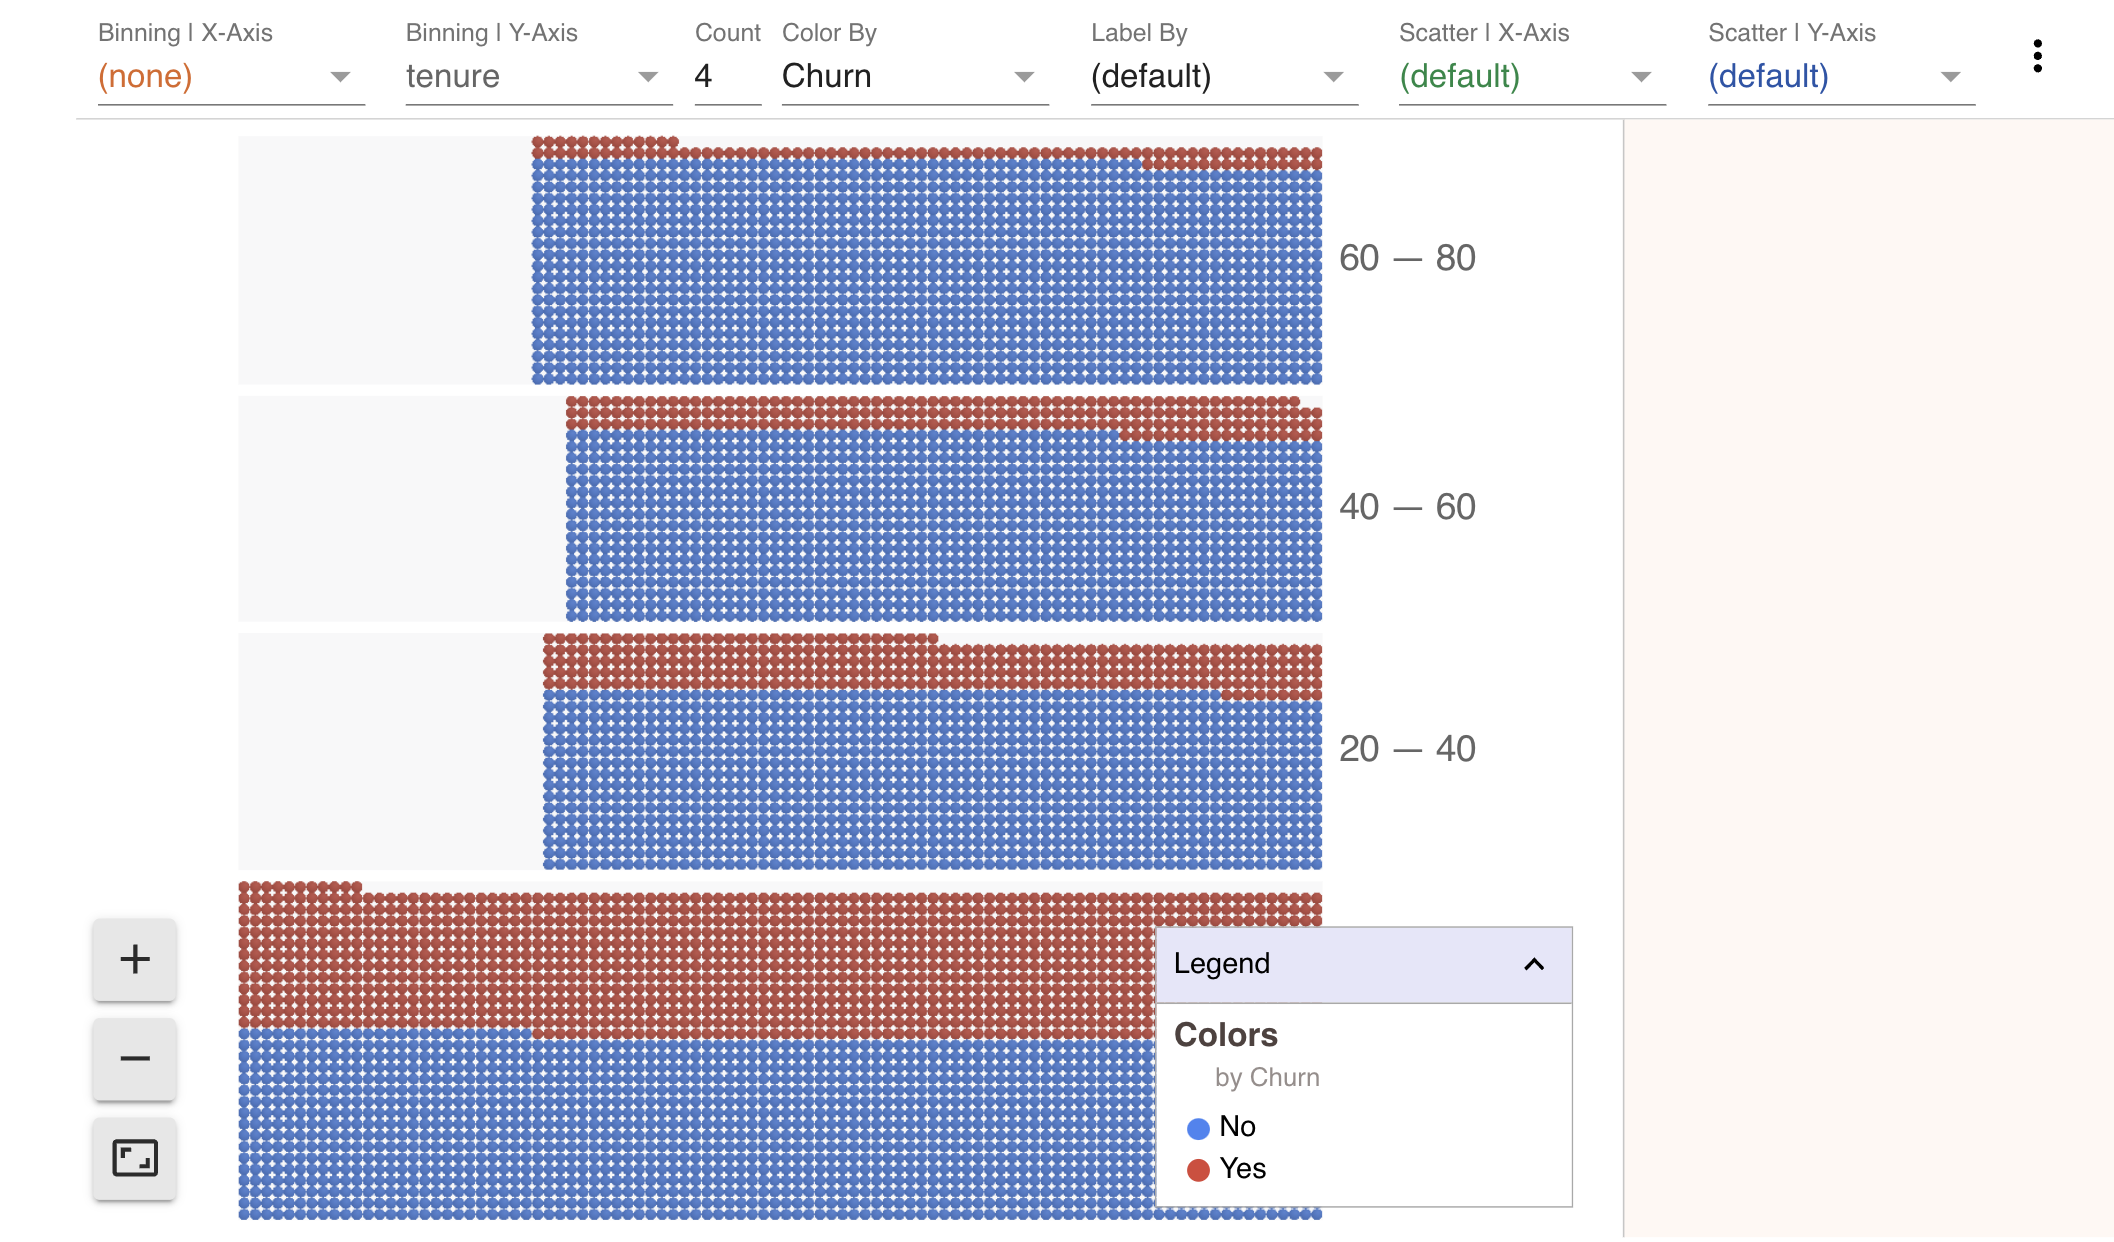

In [12]:
from IPython.display import Image, display

# Path to the image files
total_charge_image_path = 'static/total_charge_group.png'
monthly_charge_image_path = 'static/monthly_charge_group.png'
tenure_image_path = 'static/tenure_group.png'

# Display the scaled images
display(Image(filename=total_charge_image_path, width=800))
display(Image(filename=monthly_charge_image_path, width=800))
display(Image(filename=tenure_image_path, width=800))


In [13]:
# Define the bin edges and labels for MonthlyCharges
monthly_charges_bin_edges = [0, 40, 70, 90, float('inf')]
monthly_charges_labels = ['0-40', '40-70', '70-90', '90+']
transformed_telco_df['monthlychargesGroup'] = pd.cut(transformed_telco_df['MonthlyCharges'], bins=monthly_charges_bin_edges, labels=monthly_charges_labels)

# Define the bin edges and labels for TotalCharges
total_charges_bin_edges = [0, 2000, 5000, 7000, float('inf')]
total_charges_labels = ['0-2k', '2k-5k', '5k-7k', '7k+']
transformed_telco_df['totalchargesGroup'] = pd.cut(transformed_telco_df['TotalCharges'], bins=total_charges_bin_edges, labels=total_charges_labels)

# Define the bin edges and labels for Tenure
tenure_bin_edges = [0, 20, 40, 60, float('inf')]
tenure_labels = ['0-20', '20-40', '40-60', '60+']
transformed_telco_df['tenureGroup'] = pd.cut(transformed_telco_df['tenure'], bins=tenure_bin_edges, labels=tenure_labels)

# Display the updated DataFrame
transformed_telco_df.head()

SeniorCitizen Partner Dependents  tenure InternetService OnlineSecurity  \
0            No     Yes         No       1             DSL             No   
1            No      No         No      34             DSL            Yes   
2            No      No         No       2             DSL            Yes   
3            No      No         No      45             DSL            Yes   
4            No      No         No       2     Fiber optic             No   

  OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  \
0          Yes               No          No          No              No   
1           No              Yes          No          No              No   
2          Yes               No          No          No              No   
3           No              Yes         Yes          No              No   
4           No               No          No          No              No   

         Contract PaperlessBilling              PaymentMethod  MonthlyCharges  \
0  Month-to-month              Yes           Electronic check           29.85   
1        One year               No               Mailed check           56.95   
2  Month-to-month              Yes               Mailed check           53.85   
3        One year               No  Bank transfer (automatic)           42.30   
4  Month-to-month              Yes           Electronic check           70.70   

   TotalCharges Churn monthlychargesGroup totalchargesGroup tenureGroup  
0         29.85    No                0-40              0-2k        0-20  
1       1889.50    No               40-70              0-2k       20-40  
2        108.15   Yes               40-70              0-2k        0-20  
3       1840.75    No               40-70              0-2k       40-60  
4        151.65   Yes               70-90              0-2k        0-20

**Label & Dummy encoding**

In [14]:
# Define columns for one-hot encoding
one_hot_encoding_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                            'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod', 'totalchargesGroup',
                           'tenureGroup', 'monthlychargesGroup']
transformed_telco_df = pd.get_dummies(transformed_telco_df, columns=one_hot_encoding_columns,  drop_first= True, dtype=int)


# Define binary columns for label encoding
label_encoding_columns = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'Churn']
mapping_dict = {'Female': 1, 'Male': 0, 'Yes': 1, 'No': 0}
for column in label_encoding_columns:
    transformed_telco_df[column] = transformed_telco_df[column].map(mapping_dict.get)

In [16]:
transformed_telco_df.columns.nunique()

36

# Feature Selection

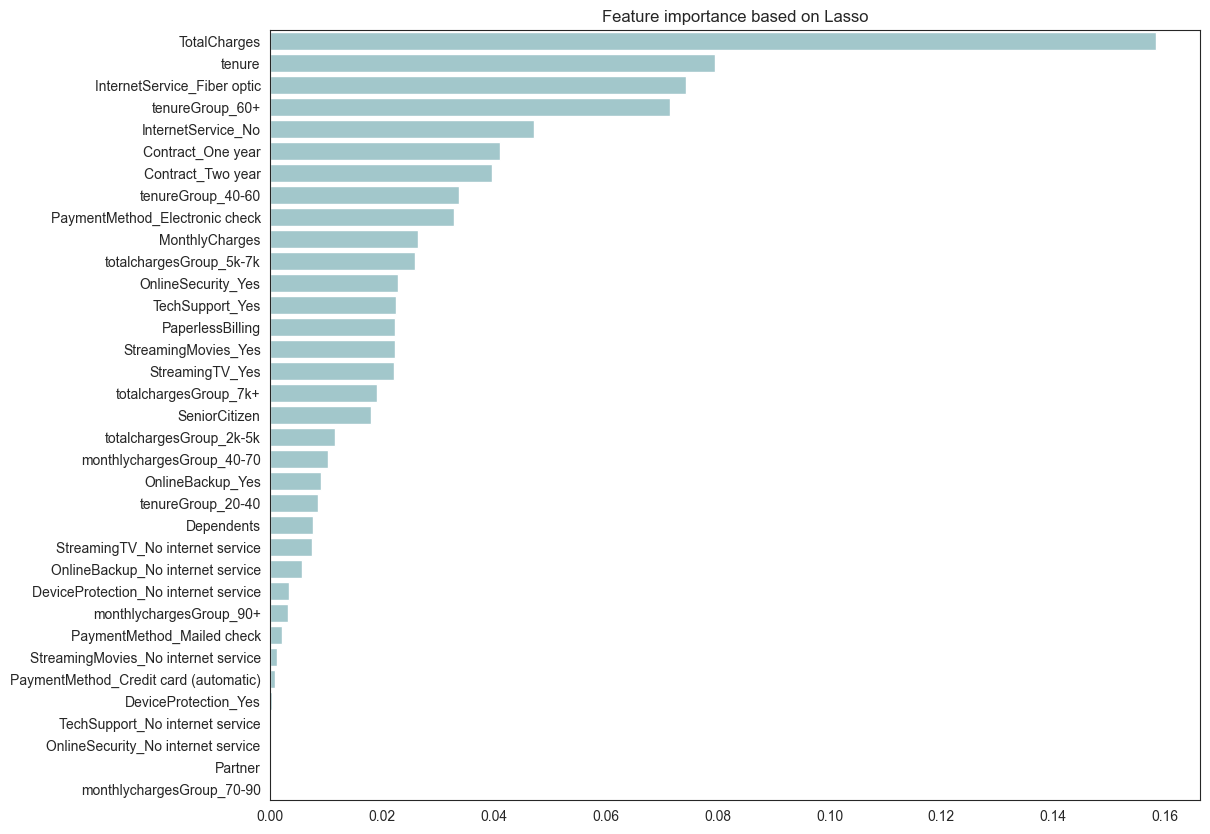

In [17]:
# Prepare the data
X, y = transformed_telco_df.drop('Churn', axis=1), transformed_telco_df['Churn']

# Scale the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the optimal alpha value using LassoCV
alphas = 10 ** np.linspace(-3, 3, 200)
lasso_model = LassoCV(alphas=alphas, cv=5)
lasso_model.fit(X_scaled, y)

# Plot the feature importance
lasso_coefs = pd.Series(abs(lasso_model.coef_), index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x=lasso_coefs.values, y=lasso_coefs.index, color=helper.PALETTE[0])
ax.set_title("Feature importance based on Lasso")
plt.show()

In [18]:
chosen_features = list(set(lasso_coefs.nlargest(22).index))
print(f"Chosen features: \n{chosen_features}")

Chosen features: 
['TotalCharges', 'InternetService_No', 'Contract_Two year', 'tenure', 'tenureGroup_60+', 'StreamingMovies_Yes', 'MonthlyCharges', 'tenureGroup_20-40', 'TechSupport_Yes', 'totalchargesGroup_5k-7k', 'InternetService_Fiber optic', 'monthlychargesGroup_40-70', 'totalchargesGroup_2k-5k', 'StreamingTV_Yes', 'PaymentMethod_Electronic check', 'OnlineSecurity_Yes', 'SeniorCitizen', 'Contract_One year', 'tenureGroup_40-60', 'totalchargesGroup_7k+', 'PaperlessBilling', 'OnlineBackup_Yes']


### Train Models

In [22]:
# Specify the columns to be normalized
normalized_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
transformed_telco_df[normalized_columns] = scaler.fit_transform(transformed_telco_df[normalized_columns])

In [48]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def nested_cross_validation(X, y, models, cv=5):
    # Outer loop: hyperparameter tuning
    best_models = []
    best_metrics = {}
    
    for model in models:
        gs = RandomizedSearchCV(model['estimator'], model['hyperparameters'], cv=cv, verbose=2, n_jobs=-1, scoring='neg_mean_squared_error')
        gs.fit(X, y)

        # Log metrics for all model types
        metrics = cross_validate(gs.best_estimator_, X, y, cv=cv, n_jobs=-1, scoring=["accuracy", "roc_auc", "f1"])
        
        for metric, values in metrics.items():
            print(f"{model['name']} {metric}: {values.mean()}")

        # Check if this is the best model based on accuracy
        if not best_models or gs.best_score_ > best_metrics['accuracy']:
            best_models = [model['name']]
            best_metrics = {'accuracy': gs.best_score_,
                            'AUC': roc_auc_score(y, gs.best_estimator_.predict_proba(X)[:, 1]),
                            'F1': f1_score(y, gs.best_estimator_.predict(X))
                           }

    # Inner loop: model training and evaluation
    for model_name in best_models:
        model = models[model_name]['estimator']
        model = model.set_params(**gs.best_params_)
        cv_scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1, scoring='neg_mean_squared_error')
        print(f"Best model: {model_name}")
        print(f"Cross-validation scores: {cv_scores}")

In [44]:
X, y = transformed_telco_df.copy().drop('Churn', axis=1), transformed_telco_df.copy()['Churn']

In [45]:
# Define the models and corresponding hyperparameters to be tuned
models = [
    {
        'name': 'dummy_classifier',
        'estimator': DummyClassifier(strategy='most_frequent'),
        'hyperparameters': {}
    },
    {
        'name': 'k_nearest_neighbors',
        'estimator': KNeighborsClassifier(),
        'hyperparameters': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'logistic_regression',
        'estimator': LogisticRegression(max_iter=1000, solver='liblinear'),
        'hyperparameters': {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10]
        }
    },
    {
        'name': 'support_vector_machines',
        'estimator': SVC(),
        'hyperparameters': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    {
        'name': 'random_forest',
        'estimator': RandomForestClassifier(),
        'hyperparameters': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10]
        }
    },
    {
        'name': 'gradient_boosting',
        'estimator': GradientBoostingClassifier(),
        'hyperparameters': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.01],
            'max_depth': [3, 5]
        }
    }
]


In [49]:
nested_cross_validation(X, y, models)

/Users/chaubui/Documents/Prepare/customer_churn_analysis/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
dummy_classifier fit_time: 0.004486799240112305
dummy_classifier score_time: 0.0036031723022460936
dummy_classifier test_accuracy: 0.7341772139101284
dummy_classifier test_roc_auc: 0.5
dummy_classifier test_f1: 0.0
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/Users/chaubui/Documents/Prepare/customer_churn_analysis/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.0s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END ...................

/Users/chaubui/Documents/Prepare/customer_churn_analysis/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1,

/Users/chaubui/Documents/Prepare/customer_churn_analysis/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.6s
[CV] END ...................max_depth=None, n_estimators=100; total time=   0.7s
[CV] END ...................max_depth=None, n_estimators=200; total time=   1.2s
[CV] END ...................max_depth=None, n_estimators=200; total time=   1.2s
[CV] END ...................max_depth=None, n_estimators=200; total time=   1.3s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.4s
[CV] END ...................max_depth=None, n_estimators=200; total time=   1.2s
[CV] END ...................max_depth=None, n_estimators=200; total time=   1.2s
[CV] END ......................max_depth=5, n_estimators=100; total time=   0.5s
[CV] END ...................

TypeError: list indices must be integers or slices, not str

In [40]:
X = transformed_telco_df.copy()

outer_cv = KFold(n_splits=10, shuffle=True, random_state=41)

for i, (train_idxs_outer, test_idxs_outer) in enumerate(outer_cv.split(X, y)):
    print(f"Fold {i}:")
    X_train_outer, X_test_outer = X.iloc[train_idxs_outer], X.iloc[test_idxs_outer]
    y_train_outer, y_test_outer = y.iloc[train_idxs_outer], y.iloc[test_idxs_outer]

    inner_cv = KFold(n_splits=5)
    preds_outer_ensembled = []
    
    for train_idxs_inner, test_idxs_inner in inner_cv.split(X_train_outer):
        model = RandomForestClassifier()
        X_train_inner, X_test_inner = X_train_outer.iloc[train_idxs_inner], X_train_outer.iloc[test_idxs_inner]
        y_train_inner, y_test_inner = y_train_outer.iloc[train_idxs_inner], y_train_outer.iloc[test_idxs_inner]
        
        model = model.fit(X_train_inner, y_train_inner)
        preds_inner = model.predict(X_test_inner)     
        preds_outer = model.predict(X_test_outer)     
        
        accuracy_inner = accuracy_score(y_test_inner, preds_inner)
        preds_outer_ensembled.append(preds_outer)
    
    preds_outer_ensembled = np.mean(preds_outer_ensembled, axis=0)
    accuracy_outer = accuracy_score(y_test_outer, preds_outer_ensembled)
    print(preds_outer_ensembled)

Fold 0:
[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 

In [ ]:
def nested_cross_validation(X, y, hyperparameters):
    # Outer loop: hyperparameter tuning
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    best_params = None
    best_score = -np.inf
    for params in hyperparameters:
        inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
        scores = cross_val_score(LinearRegression(**params), X, y, cv=inner_cv, scoring='neg_mean_squared_error')
        mean_score = np.mean(scores)
        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    # Inner loop: model training and evaluation
    lr = LinearRegression(**best_params)
    cv_scores = cross_val_score(lr, X, y, cv=outer_cv, scoring='neg_mean_squared_error')
    return np.mean(cv_scores)

In [ ]:
# Specify the columns to be normalized
normalized_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
transformed_telco_df[normalized_columns] = scaler.fit_transform(transformed_telco_df[normalized_columns])

# Split data
X_train, X_test, y_train, y_test = train_test_split(transformed_telco_df[chosen_features], transformed_telco_df['Churn'], test_size=.2, random_state=30)

In [19]:
# Specify the columns to be normalized
normalized_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
transformed_telco_df[normalized_columns] = scaler.fit_transform(transformed_telco_df[normalized_columns])

# Split data
X_train, X_test, y_train, y_test = train_test_split(transformed_telco_df[chosen_features], transformed_telco_df['Churn'], test_size=.2, random_state=30)

In [21]:
# Set up cross-validation
cv = 5

# Define the models and corresponding hyperparameters to be tuned
models = [
    {
        'name': 'dummy_classifier',
        'estimator': DummyClassifier(strategy='most_frequent'),
        'hyperparameters': {}
    },
    {
        'name': 'k_nearest_neighbors',
        'estimator': KNeighborsClassifier(),
        'hyperparameters': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance']
        }
    },
    {
        'name': 'logistic_regression',
        'estimator': LogisticRegression(max_iter=1000, solver='liblinear'),
        'hyperparameters': {
            'penalty': ['l1', 'l2'],
            'C': [0.1, 1, 10]
        }
    },
    {
        'name': 'support_vector_machines',
        'estimator': SVC(),
        'hyperparameters': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    {
        'name': 'random_forest',
        'estimator': RandomForestClassifier(),
        'hyperparameters': {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 5, 10]
        }
    },
    {
        'name': 'gradient_boosting',
        'estimator': GradientBoostingClassifier(),
        'hyperparameters': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.1, 0.01],
            'max_depth': [3, 5]
        }
    }
]

# Iterate through the models and corresponding hyperparameters to train and tune them
best_models = []
best_metrics = {}

for model in models:
    print(f"\nTraining {model['name']} model...")
    
    # Set up grid search for hyperparameter tuning
    gs = GridSearchCV(model['estimator'], model['hyperparameters'], cv=cv, verbose=2, n_jobs=-1, scoring='accuracy')
    gs.fit(X_train, y_train)

    # Log metrics for all model types
    metrics = cross_validate(gs.best_estimator_, X_train, y_train, cv=cv, n_jobs=-1,
                             scoring=["accuracy", "roc_auc", "f1"])
    
    for metric, values in metrics.items():
        print(f"{model['name']} {metric}: {values.mean()}")

    # Check if this is the best model based on accuracy
    if not best_models or gs.best_score_ > best_metrics['accuracy']:
        best_models = [model['name']]
        best_metrics = {'accuracy': gs.best_score_,
                        'AUC': roc_auc_score(y_train, gs.best_estimator_.predict_proba(X_train)[:, 1]),
                        'F1': f1_score(y_train, gs.best_estimator_.predict(X_train))
                       }

print("\nBest Models:")
for model in best_models:
    print(f"- {model}")

print("\nBest Metrics:")
for metric, value in best_metrics.items():
    print(f"- {metric}: {value}")



Training dummy_classifier model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
dummy_classifier fit_time: 0.003823089599609375
dummy_classifier score_time: 0.0019855499267578125
dummy_classifier test_accuracy: 0.7291963621984976
dummy_classifier test_roc_auc: 0.5
dummy_classifier test_f1: 0.0

Training k_nearest_neighbors model...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END .....................n_neighb

### Hyperparameter tuning
There are multiple techniques to find the best hyperparameters for a model. The most popular methods are (1) grid search, (2) random search, and (3) bayesian optimization. Grid search test all combinations of hyperparameters and select the best performing one. It is a really time-consuming method, particularly when the number of hyperparameters and values to try are really high. But in this model, our samples are small, so I go with Grid search.


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
grid_parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [2000, 3000, 4000],
    'class_weight': [None, 'balanced']
}

# Define the GridSearchCV class for exhaustive search
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=grid_parameters,
    cv=5,
    n_jobs=-1
)

# Fit the model for grid search
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [2000, 3000, 4000],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']})

In [23]:
grid_search.best_estimator_

LogisticRegression(C=1, max_iter=2000, solver='saga')

In [24]:
# Get the coefficients from the best logistic regression model
coefficients = grid_search.best_estimator_.coef_

# Print the coefficients
for feature_name, coef in sorted(zip(coefficients[0], X_train.columns)):
    print(f"{feature_name}: {coef}")

-3.451265091873096: tenure
-1.5677317927947796: Contract_Two year
-1.1141385752090336: InternetService_No
-0.7529083861577405: TotalCharges
-0.7444708488948937: Contract_One year
-0.3483622415154917: OnlineSecurity_Yes
-0.32355717482127744: TechSupport_Yes
-0.30154799697446427: MonthlyCharges
-0.12332774218163746: OnlineBackup_Yes
-0.08262024892443193: monthlychargesGroup_40-70
0.010605694307636996: tenureGroup_20-40
0.2632498430227372: SeniorCitizen
0.2800866602916133: StreamingTV_Yes
0.34534893501961494: PaperlessBilling
0.35359909950959223: PaymentMethod_Electronic check
0.36467653229502317: StreamingMovies_Yes
0.4230395157472879: totalchargesGroup_2k-5k
0.5769335208805628: tenureGroup_40-60
0.8398141930430514: tenureGroup_60+
0.8501117375059546: InternetService_Fiber optic
0.9993454306845764: totalchargesGroup_5k-7k
1.2836560482355568: totalchargesGroup_7k+


### Evaluate Your System on the Test Set

In [25]:
final_model = grid_search.best_estimator_
grid_search_predictions = grid_search.predict(X_test)
confusion_matrix_result = confusion_matrix(y_test, grid_search_predictions)

print(f"\nConfusion Matrix: \n{confusion_matrix_result}")
print(f"\nClassififcation report: \n{classification_report(y_test, grid_search_predictions)}")
print(f"\nAccuracry Score: {accuracy_score(y_test, grid_search_predictions)*100:.2f}%")


Confusion Matrix: 
[[947 114]
 [158 188]]

Classififcation report: 
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      1061
           1       0.62      0.54      0.58       346

    accuracy                           0.81      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.80      0.81      0.80      1407


Accuracry Score: 80.67%


By tuning hyperparameter, I have achieved the optimised Recall rate, which is defined as the number of churned customers predicted correctly at 81%. Both F1 and precision also improved compared to the previous hyper-parameters.

In [26]:
import joblib 
joblib.dump(grid_search_predictions, 'model/loreg_customer_churn_2307015.pkl')

['model/loreg_customer_churn_2307015.pkl']